# :: Annotated [Annotated Transformer](https://nlp.seas.harvard.edu/annotated-transformer/) ::


# Intro

- [Annotated Transformer](https://nlp.seas.harvard.edu/annotated-transformer/) is a comprehensive guide for the original transformer architecture.
- This notebook is supplementary to it, where I tried to explicitly annotate the dimensions used in the architecture.


In [1]:
import copy
import math

import torch
from torch import nn
import torch.nn.functional as F
import numpy as np


In [2]:
from torch.optim.lr_scheduler import LambdaLR


In [3]:
class DummyOptimizer(torch.optim.Optimizer):
    def __init__(self):
        self.param_groups = [{"lr": 0}]
        None

    def step(self):
        None

    def zero_grad(self, set_to_none=False):
        None


class DummyScheduler:
    def step(self):
        None


# Part 1: Architecture


#### We will go over the transformer architecture.


# High-Level View


### There are 5 players in the Transformer:

- encoder
- decoder
- source embedder
- target embedder
- generator


<img src="architecture_high_level.png" width="400rem">


#### Let's first convert the high-level part into code.

- We name it `EncoderDecoder`.
- It take the 5 components as inputs.


In [4]:
class EncoderDecoder(nn.Module):
    def __init__(self, encoder, decoder, src_embed, tgt_embed, generator):
        super(EncoderDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = src_embed
        self.tgt_embed = tgt_embed
        self.generator = generator

    def encode(self, src, src_mask):
        embedded_src = self.src_embed(src)
        return self.encoder(embedded_src, src_mask)

    def decode(self, memory, src_mask, tgt, tgt_mask):
        embedded_tgt = self.tgt_embed(tgt)
        return self.decoder(embedded_tgt, memory, src_mask, tgt_mask)

    def forward(self, src, tgt, src_mask, tgt_mask):
        memory = self.encode(src, src_mask)
        return self.decode(memory, src_mask, tgt, tgt_mask)


#### OK, now we will create each module one by one. Let's start from the generator first.


# Generator


- Input: the output of the decoder
- Apply a standard linear transform
- Apply softmax
- Produce probabilities


In [5]:
from torch.nn.functional import log_softmax


In [6]:
class Generator(nn.Module):
    def __init__(self, d_in, vocab):
        super(Generator, self).__init__()
        self.proj = nn.Linear(d_in, vocab)

    def forward(self, x):
        return log_softmax(self.proj(x), dim=-1)


# Encoder


- Apply EncoderLayer 6 times.
  - Each EncoderLayer consists 2 sub-layers::
    - Self-Attention
    - Feed Forward
  - These 2 sub-layers are connected sequentially by SublayerConnection:
    - x + Dropout (Layer (LayerNorm (x)))
- Apply Layer Normalization.


<img src="encoder.png" width="300rem">


#### We first define 3 things

- `clones` function: for repeated blocks
- `LayerNorm` class: for normalization
- `SublayerConnection` class: connecting sublayer1 (multi-head attention) with sublayer2 (feed forward).


In [7]:
def clones(module, N):
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])


In [8]:
class LayerNorm(nn.Module):
    def __init__(self, features, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.a_2 = nn.Parameter(torch.ones(features))
        self.b_2 = nn.Parameter(torch.zeros(features))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.a_2 * (x - mean) / (std + self.eps) + self.b_2


In [9]:
class SublayerConnection(nn.Module):
    def __init__(self, size, dropout):
        super(SublayerConnection, self).__init__()
        self.dropout = nn.Dropout(dropout)
        self.norm = LayerNorm(size)

    def forward(self, x, sublayer):
        return x + self.dropout(sublayer(self.norm(x)))


#### Now, we are ready to create the `EncoderLayer` class and `Encoder` class.

- `EncoderLayer`
  - self-attention + feed forward
  - connected sequentually by `SublayerConnection`: x + Dropout ( Layer ( LayerNorm (x)))
- `Encoder`: 6 sequences of `EncoderLayer`.


In [10]:
class EncoderLayer(nn.Module):
    def __init__(self, size, self_attn, feed_forward, dropout):
        super(EncoderLayer, self).__init__()
        self.size = size
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        self.sublayer_connections = clones(SublayerConnection(size, dropout), 2)

    def forward(self, x, mask):
        sublayer1 = lambda x: self.self_attn(x, x, x, mask)
        sublayer2 = self.feed_forward
        x = self.sublayer_connections[0](x, sublayer1)
        return self.sublayer_connections[1](x, sublayer2)


In [11]:
class Encoder(nn.Module):
    def __init__(self, layer, N):
        super(Encoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)

    def forward(self, x, mask):
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)


#### Next, we will implement the `DecoderLayer` and `Decoder`.


# Decoder


- `DecoderLayer`
  - self-attention + source-attention + feed forward
  - connected sequentually by `SublayerConnection`: x + Dropout ( Layer ( LayerNorm (x)))
- `Decoder`: 6 times of `DecoderLayer`


<img src="decoder.png" width="300rem">


In [12]:
class DecoderLayer(nn.Module):
    def __init__(self, size, self_attn, src_attn, feed_forward, dropout):
        super(DecoderLayer, self).__init__()
        self.size = size
        self.self_attn = self_attn
        self.src_attn = src_attn
        self.feed_forward = feed_forward
        self.sublayer_connections = clones(SublayerConnection(size, dropout), 3)

    def forward(self, x, memory, src_mask, tgt_mask):
        sublayer1 = lambda x: self.self_attn(x, x, x, tgt_mask)
        sublayer2 = lambda x: self.src_attn(x, memory, memory, src_mask)
        sublayer3 = self.feed_forward
        x = self.sublayer_connections[0](x, sublayer1)
        x = self.sublayer_connections[1](x, sublayer2)
        return self.sublayer_connections[2](x, sublayer3)


In [13]:
class Decoder(nn.Module):
    def __init__(self, layer, N):
        super(Decoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)

    def forward(self, x, memory, src_mask, tgt_mask):
        for layer in self.layers:
            x = layer(x, memory, src_mask, tgt_mask)
        return self.norm(x)


#### But what are `src_mask` or `tgt_mask`?


# Mask

- Notice that we need masks - to filter which information to be used or not.
- Here is an example of `tgt_mask`: the predictions for position i can rely only on the positions up to i-1.


In [14]:
def subsequent_mask(size):
    attn_shape = (1, size, size)
    subsequent_mask = torch.triu(torch.ones(attn_shape), diagonal=1).type(torch.uint8)
    return subsequent_mask == 0


In [15]:
torch.ones((1, 5, 5))


tensor([[[1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1.]]])

In [16]:
torch.triu(torch.ones((1, 5, 5)), diagonal=1)


tensor([[[0., 1., 1., 1., 1.],
         [0., 0., 1., 1., 1.],
         [0., 0., 0., 1., 1.],
         [0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 0.]]])

In [17]:
torch.triu(torch.ones((1, 5, 5)), diagonal=1) == 0


tensor([[[ True, False, False, False, False],
         [ True,  True, False, False, False],
         [ True,  True,  True, False, False],
         [ True,  True,  True,  True, False],
         [ True,  True,  True,  True,  True]]])

# Attention


- One of the critical things in the attention architecture is to figure out dimensions of:
  - input
  - query
  - key
  - value
  - output
- The original transformer paper uses identical dimensions for these quantities, but they don't have to be.
- Thus, we modify the `MultiHeadedAttention` class presented in [Annotated Transformer](https://nlp.seas.harvard.edu/annotated-transformer/) such that the dimensions are flexible.


#### In the below is the diagram for this example.


<img src="attn_dimensions.png" width="1200rem">


# Attention: softmax(QK^T)\*V.


In [18]:
def attention(Q, K, V, mask=None, dropout=None, silent=True):
    d_k = K.size(-1)
    QK = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(d_k)
    if not silent:
        print("\t\tQK:", QK.size())
    if mask is not None:
        QK = QK.masked_fill(mask == 0, -1e9)
    QK_softmax = QK.softmax(dim=-1)
    if not silent:
        print("\t\tQK_softmax:", QK_softmax.size())
    if dropout is not None:
        QK_softmax = nn.Dropout(dropout)(QK_softmax)
    QK_softmax_V = torch.matmul(QK_softmax, V)
    if not silent:
        print("\t\tQK_softmax_V", QK_softmax_V.size())
    return QK_softmax_V, QK_softmax


# Multi Headed Attention

- `d_in`: input dim
- `D_q`: concatenated Q dim = `d_q` (Q dim) \* `h`
- `D_k`: concatenated K dim = `d_k` (K dim) \* `h`
- `D_v`: concatenated V dim = `d_v` (K dim) \* `h`
- `d_out`: output dim


In [19]:
class MultiHeadedAttention(nn.Module):
    def __init__(self, d_in, D_q, D_k, D_v, d_out, h, dropout=0.1, silent=True):
        super(MultiHeadedAttention, self).__init__()

        self.linear_Q = nn.Linear(d_in, D_q, bias=False)
        self.linear_K = nn.Linear(d_in, D_k, bias=False)
        self.linear_V = nn.Linear(d_in, D_v, bias=False)
        self.linear_Wo = nn.Linear(D_v, d_out)

        self.d_in = d_in
        self.D_q = D_q
        self.D_k = D_k
        self.D_v = D_v
        self.d_out = d_out
        self.h = h
        self.dropout = dropout
        self.silent = silent

    def forward(self, query, key, value, mask=None):
        if not self.silent:
            print("MultiHeadedAttention")
        if mask is not None:
            mask = mask.unsqueeze(1)
        nbatches = query.size(0)

        B, T_q, _ = query.shape
        B, T_k, _ = key.shape
        B, T_v, _ = value.shape
        if not self.silent:
            print("\tBefore Linear Mapping:")
            print("\t\tquery (= X):", query.size())
            print("\t\tkey (= X):", key.size())
            print("\t\tvalue (= X):", value.size())
        Q = self.linear_Q(query).view(B, T_q, self.h, -1).transpose(1, 2)
        K = self.linear_K(key).view(B, T_k, self.h, -1).transpose(1, 2)
        V = self.linear_V(value).view(B, T_v, self.h, -1).transpose(1, 2)
        if not self.silent:
            print("\t\tWq:", self.linear_Q.weight.size())
            print("\t\tWk:", self.linear_K.weight.size())
            print("\t\tWv:", self.linear_V.weight.size())
            print("\tAfter Linear Mapping:")
            print("\t\tQ (= X * Wq)", Q.size())
            print("\t\tK (= X * Wk)", K.size())
            print("\t\tV (= X * Wv):", V.size())

            print("\n\tCalculating Attention: start")
        Z_i, _ = attention(Q, K, V, mask=mask, dropout=self.dropout, silent=self.silent)
        if not self.silent:
            print("\tCalculation Attention: end\n")
            print("\tZ_i:", Z_i.size())
        Z_i_concat = Z_i.transpose(1, 2).contiguous().view(nbatches, -1, self.D_v)
        if not self.silent:
            print("\tZ_i_concat:", Z_i_concat.size())

        Z = self.linear_Wo(Z_i_concat)

        del query
        del key
        del value
        if not self.silent:
            print("\tWo:", self.linear_Wo.weight.size())
            print("\tZ (= Z_i_concat * Wo):", Z.size())
        return Z


# Example: Dimensions in Multi-Headed Attention

- We will print out the dimensions of each component at each step.
- Confirm they are consistent with the above diagram.


In [20]:
# batch size
B = 64  # batch size

# sequence length
n_seq = 3
T_q = n_seq
T_k = n_seq
T_v = n_seq

# number of heads
h = 2

# input dimension
d_in = 6

# linear mapping dimension for Q, K, V
d_q = 4  # single head
d_k = 4  # single head
d_v = 4  # single head
D_q = d_q * h  # multi-head
D_k = d_k * h  # multi-head
D_v = d_v * h  # multi-head

# output dimension
d_out = d_in


mha = MultiHeadedAttention(
    d_in=d_in,
    D_q=D_q,
    D_k=D_k,
    D_v=D_v,
    d_out=d_out,
    h=h,
    dropout=0.1,
    silent=False,
)

query = torch.tensor(np.ones([B, T_q, d_in])).float()
key = torch.tensor(np.ones([B, T_k, d_in])).float()
value = torch.tensor(np.ones([B, T_v, d_in])).float()
result = mha.forward(query, key, value)
print("\n\tresult:", result.size())
print("\n")


MultiHeadedAttention
	Before Linear Mapping:
		query (= X): torch.Size([64, 3, 6])
		key (= X): torch.Size([64, 3, 6])
		value (= X): torch.Size([64, 3, 6])
		Wq: torch.Size([8, 6])
		Wk: torch.Size([8, 6])
		Wv: torch.Size([8, 6])
	After Linear Mapping:
		Q (= X * Wq) torch.Size([64, 2, 3, 4])
		K (= X * Wk) torch.Size([64, 2, 3, 4])
		V (= X * Wv): torch.Size([64, 2, 3, 4])

	Calculating Attention: start
		QK: torch.Size([64, 2, 3, 3])
		QK_softmax: torch.Size([64, 2, 3, 3])
		QK_softmax_V torch.Size([64, 2, 3, 4])
	Calculation Attention: end

	Z_i: torch.Size([64, 2, 3, 4])
	Z_i_concat: torch.Size([64, 3, 8])
	Wo: torch.Size([6, 8])
	Z (= Z_i_concat * Wo): torch.Size([64, 3, 6])

	result: torch.Size([64, 3, 6])




# (Position-wise) Feed-Forward

- linear -> relu -> linear
- no particular comment.


In [21]:
class PositionwiseFeedForward(nn.Module):
    def __init__(self, d_out, d_ff, dropout=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.w_1 = nn.Linear(d_out, d_ff)
        self.w_2 = nn.Linear(d_ff, d_out)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.w_2(self.dropout(self.w_1(x).relu()))


# Word Embedding

- No particular comment.


In [22]:
class Embeddings(nn.Module):
    def __init__(self, d_model, vocab):
        super(Embeddings, self).__init__()
        self.lut = nn.Embedding(vocab, d_model)
        self.d_model = d_model

    def forward(self, x):
        return self.lut(x) * math.sqrt(self.d_model)  # "lut": look-up-table.


# Positional Encoding

- Combination of sine and cosine functions.
- No particular comment.


In [23]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model)
        )
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer("pe", pe)

    def forward(self, x):
        x = x + self.pe[:, : x.size(1)].requires_grad_(False)
        return self.dropout(x)


#### (\*\*) For those who are not familiar with `unsqueeze` (and `squeeze`) in pytorch, see below (excerpted from [stackoverflow](https://stackoverflow.com/questions/61598771/pytorch-squeeze-and-unsqueeze)):

<img src="squeeze_unsqueeze.png" width="600rem">


# Example: Positional Encoding from Sine and Cosine functions


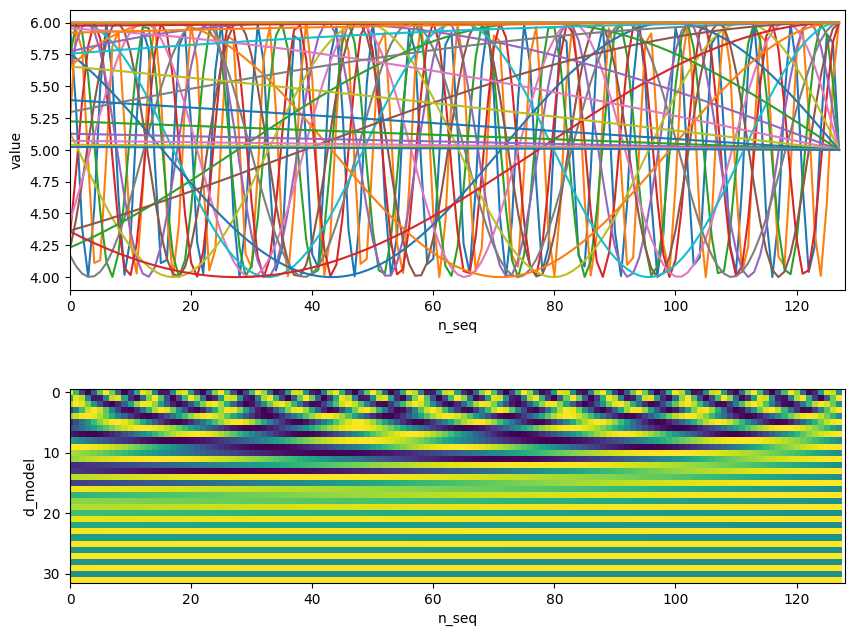

In [24]:
batch_size = 1
d_model = 32
n_seq = 128

x = torch.ones(batch_size, n_seq, d_model) * 5
pe = PositionalEncoding(d_model=d_model, dropout=0, max_len=n_seq)
y = pe(x)

import matplotlib.pyplot as plt

data_plot = y[0, :, :].data.numpy()[::-1]
fig, axes = plt.subplots(2, 1, figsize=(10, 8))
for i, ax in enumerate(
    axes.reshape(
        2,
    )
):
    if i == 0:
        ax.plot(np.arange(n_seq), data_plot)
        ax.set_ylabel("value")
    elif i == 1:
        ax.imshow(data_plot.transpose(), interpolation="none")
        ax.set_ylabel("d_model")
    ax.set_xlim([0, n_seq])
    ax.set_xlabel("n_seq")
fig.savefig("pos_enc.png", dpi=200, facecolor="white")


#### ....and now we're ready to build a full transformer model.


In [25]:
def make_model(src_vocab, tgt_vocab, N=6, d_model=512, d_ff=2048, h=8, dropout=0.1):
    dc = copy.deepcopy
    attn = MultiHeadedAttention(
        d_in=d_model,
        D_q=d_model * h,
        D_k=d_model * h,
        D_v=d_model * h,
        d_out=d_model,
        h=h,
        dropout=dropout,
    )
    ff = PositionwiseFeedForward(d_out=d_model, d_ff=d_ff)
    position = PositionalEncoding(d_model=d_model, dropout=dropout)

    encoder = Encoder(
        EncoderLayer(
            size=d_model, self_attn=dc(attn), feed_forward=dc(ff), dropout=dropout
        ),
        N=N,
    )
    decoder = Decoder(
        DecoderLayer(
            size=d_model,
            self_attn=dc(attn),
            src_attn=dc(attn),
            feed_forward=dc(ff),
            dropout=dropout,
        ),
        N=N,
    )
    src_embed = nn.Sequential(
        Embeddings(d_model=d_model, vocab=src_vocab), dc(position)
    )
    tgt_embed = nn.Sequential(
        Embeddings(d_model=d_model, vocab=tgt_vocab), dc(position)
    )
    generator = Generator(d_in=d_model, vocab=tgt_vocab)
    model = EncoderDecoder(
        encoder=encoder,
        decoder=decoder,
        src_embed=src_embed,
        tgt_embed=tgt_embed,
        generator=generator,
    )

    # This was important from their code.
    # Initialize parameters with Glorot / fan_avg.
    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)
    return model


# Part 2: Training


#### For training, we need to implement several components

- batch: a batch of data is the unit for model training.
- data iterator: for iteration of batches
- loss computation: to keep track of the loss while training
- optimizer: need to choose one
- learning scheduler: learning rate scheduler
- regularizer: labelsmoothing


# Batch


In [26]:
class Batch:
    def __init__(self, src, tgt=None, pad=0):
        self.src = src
        self.src_mask = (src != pad).unsqueeze(-2)
        if tgt is not None:
            self.tgt = tgt[:, :-1]
            self.tgt_y = tgt[:, 1:]
            self.tgt_mask = self.make_std_mask(self.tgt, pad)
            self.ntokens = (self.tgt_y != pad).data.sum()

    @staticmethod
    def make_std_mask(tgt, pad):
        tgt_mask = (tgt != pad).unsqueeze(-2)
        tgt_mask = tgt_mask & subsequent_mask(tgt.size(-1)).type_as(tgt_mask.data)
        return tgt_mask


#### What is this `Batch` class about? Let's quickly check.


In [27]:
# Example: a plain sequence of integers.
src_vocab = 11
src = torch.LongTensor([range(1, src_vocab)])
tgt = torch.LongTensor([range(1, src_vocab)])
batch = Batch(src=src, tgt=tgt, pad=0)


In [28]:
batch.src


tensor([[ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]])

In [29]:
batch.tgt


tensor([[1, 2, 3, 4, 5, 6, 7, 8, 9]])

In [30]:
batch.tgt_y


tensor([[ 2,  3,  4,  5,  6,  7,  8,  9, 10]])

In [31]:
batch.tgt_mask


tensor([[[ True, False, False, False, False, False, False, False, False],
         [ True,  True, False, False, False, False, False, False, False],
         [ True,  True,  True, False, False, False, False, False, False],
         [ True,  True,  True,  True, False, False, False, False, False],
         [ True,  True,  True,  True,  True, False, False, False, False],
         [ True,  True,  True,  True,  True,  True, False, False, False],
         [ True,  True,  True,  True,  True,  True,  True, False, False],
         [ True,  True,  True,  True,  True,  True,  True,  True, False],
         [ True,  True,  True,  True,  True,  True,  True,  True,  True]]])

In [32]:
batch.ntokens


tensor(9)

# Run Epoch: train a "single" epoch

- It has 5 components:
  - Data Iterator
  - Model
  - Loss Computation
  - Optimizer
  - Schedular
- Each batch is generated from `data_iter`
  - `src`, `src_mask`, `tgt`, `tgt_y`, `tgt_mask`, `ntokens`
- train:
  - `loss_node.backward()`: computes the derivatives of loss w.r.t. the parameters.
  - `optimizer.step()`: move to the next step based on the gradients of the parameters.
  - `optimizer.zero_grad()`: clears old gradients from the last step (otherwise, it'd accumulate the gradients from all `backward` calls.)
- compute loss
  - for tracking loss history


In [33]:
import time


def run_epoch(
    data_iter,
    model,
    loss_compute,
    optimizer,
    scheduler,
):
    start = time.time()
    total_tokens = 0
    total_loss = 0
    tokens = 0
    n_accum = 0
    for i, batch in enumerate(data_iter):
        out = model.forward(batch.src, batch.tgt, batch.src_mask, batch.tgt_mask)
        loss, loss_node = loss_compute(out, batch.tgt_y, batch.ntokens)
        total_loss += loss
        total_tokens += batch.ntokens
        tokens += batch.ntokens

        loss_node.backward()
        optimizer.step()
        optimizer.zero_grad(set_to_none=True)
        scheduler.step()
        n_accum += 1
    loss_epoch = loss
    del loss
    del loss_node
    lr = optimizer.param_groups[0]["lr"]
    elapsed = time.time() - start
    print(
        (
            "Accumulation Step: %3d | Loss: %6.2f "
            + "| Tokens / Sec: %7.1f | Learning Rate: %6.1e"
        )
        % (n_accum, loss_epoch / batch.ntokens, tokens / elapsed, lr)
    )
    start = time.time()
    tokens = 0

    return total_loss / total_tokens


# Learning Rate

- We varied the learning rate over the course of training.


In [34]:
def rate(step, model_size, factor, warmup):
    if step == 0:
        step = 1
    return factor * (
        model_size ** (-0.5) * min(step ** (-0.5), step * warmup ** (-1.5))
    )


# Label Smoothing

- To prevent the model from becoming overly confident and too reliant on the training labels, which can lead to overfitting.
- Introduces a small amount of uncertainty by redistributing some of the probability mass from the true target token to other tokens in the vocabulary.
- Instead of assigning a probability of 1 to the correct token and 0 to others, label smoothing assigns a smoothed probability to all tokens.


In [35]:
class LabelSmoothing(nn.Module):
    def __init__(self, size, padding_idx, smoothing=0.0):
        super(LabelSmoothing, self).__init__()
        self.criterion = nn.KLDivLoss(reduction="sum")
        self.padding_idx = padding_idx
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.size = size
        self.true_dist = None

    def forward(self, x, target):
        assert x.size(1) == self.size
        true_dist = x.data.clone()
        true_dist.fill_(self.smoothing / (self.size - 2))
        true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        true_dist[:, self.padding_idx] = 0
        mask = torch.nonzero(target.data == self.padding_idx)
        if mask.dim() > 0:
            true_dist.index_fill_(0, mask.squeeze(), 0.0)
        self.true_dist = true_dist
        return self.criterion(x, true_dist.clone().detach())


# Synthetic Data

- Synthetic data generation for src-tgt copy task


In [36]:
def data_gen(V, batch_size, nbatches):
    for i in range(nbatches):
        data = torch.randint(1, V, size=(batch_size, V - 1))
        data[:, 0] = 1
        src = data.requires_grad_(False).clone().detach()
        tgt = data.requires_grad_(False).clone().detach()
        yield Batch(src, tgt, 0)


# Loss Computation

- No particular comment.


In [37]:
class SimpleLossCompute:
    def __init__(self, generator, criterion):
        self.generator = generator
        self.criterion = criterion

    def __call__(self, x, y, norm):
        x = self.generator(x)
        sloss = (
            self.criterion(x.contiguous().view(-1, x.size(-1)), y.contiguous().view(-1))
            / norm
        )
        return sloss.data * norm, sloss


# Example - Training model for the simple copy task


#### Greedy Decoding

- The greedy decoding strategy is a simple and straightforward approach.
- At each decoding step, the model selects the token with the highest probability as the next output.


In [38]:
def greedy_decode(model, src, src_mask, max_len, start_symbol, silent=True):
    tgt = torch.zeros(1, 1).fill_(start_symbol).type_as(src.data)
    print(f"{src=}, {tgt=}")
    for i in range(max_len - 1):
        tgt_mask = subsequent_mask(tgt.size(1))
        encoder_decoder_out = model(
            src=src, tgt=tgt, src_mask=src_mask, tgt_mask=tgt_mask
        )
        logprob = model.generator(encoder_decoder_out[:, -1])
        prob = torch.exp(logprob)
        _, next_word = torch.max(prob, dim=1)
        tgt = torch.cat(
            [tgt, torch.empty(1, 1).fill_(next_word.data[0])], dim=1
        ).type_as(src.data)
        print(f"{src=}, {tgt=}")
    return tgt


#### Without Training

In [39]:
src_vocab = 11
tgt_vocab = 11
N = 2
max_len = src.shape[1]

model = make_model(src_vocab=src_vocab, tgt_vocab=tgt_vocab, N=N)
model.eval()
src = torch.LongTensor([range(1, src_vocab)])
src_mask = torch.ones(1, 1, src_vocab - 1)

_ = greedy_decode(
    model=model,
    src=src,
    src_mask=src_mask,
    max_len=max_len,
    start_symbol=0,
    silent=False,
)


src=tensor([[ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]]), tgt=tensor([[0]])
src=tensor([[ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]]), tgt=tensor([[0, 4]])
src=tensor([[ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]]), tgt=tensor([[0, 4, 8]])
src=tensor([[ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]]), tgt=tensor([[0, 4, 8, 8]])
src=tensor([[ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]]), tgt=tensor([[0, 4, 8, 8, 8]])
src=tensor([[ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]]), tgt=tensor([[0, 4, 8, 8, 8, 8]])
src=tensor([[ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]]), tgt=tensor([[0, 4, 8, 8, 8, 8, 8]])
src=tensor([[ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]]), tgt=tensor([[0, 4, 8, 8, 8, 8, 8, 8]])
src=tensor([[ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]]), tgt=tensor([[0, 4, 8, 8, 8, 8, 8, 8, 8]])
src=tensor([[ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]]), tgt=tensor([[0, 4, 8, 8, 8, 8, 8, 8, 8, 8]])


#### With Training

In [40]:
# train
V = 11
model = make_model(src_vocab=V, tgt_vocab=V, N=2)
criterion = LabelSmoothing(size=V, padding_idx=0, smoothing=0.0)
optimizer = torch.optim.Adam(model.parameters(), lr=0.5, betas=(0.9, 0.98), eps=1e-9)
lr_scheduler = LambdaLR(
    optimizer=optimizer,
    lr_lambda=lambda step: rate(
        step, model_size=model.src_embed[0].d_model, factor=1.0, warmup=400
    ),
)
batch_size = 20
nbatches = 30
epochs = 10
model.train()
for epoch in range(epochs):
    run_epoch(
        data_iter=data_gen(V=V, batch_size=batch_size, nbatches=nbatches),
        model=model,
        loss_compute=SimpleLossCompute(model.generator, criterion),
        optimizer=optimizer,
        scheduler=lr_scheduler,
    )


Accumulation Step:  30 | Loss:   1.81 | Tokens / Sec:   333.2 | Learning Rate: 8.3e-05
Accumulation Step:  30 | Loss:   1.52 | Tokens / Sec:   312.2 | Learning Rate: 1.7e-04
Accumulation Step:  30 | Loss:   1.18 | Tokens / Sec:   291.2 | Learning Rate: 2.5e-04
Accumulation Step:  30 | Loss:   0.69 | Tokens / Sec:   315.4 | Learning Rate: 3.3e-04
Accumulation Step:  30 | Loss:   0.65 | Tokens / Sec:   306.2 | Learning Rate: 4.1e-04
Accumulation Step:  30 | Loss:   0.59 | Tokens / Sec:   305.9 | Learning Rate: 5.0e-04
Accumulation Step:  30 | Loss:   0.39 | Tokens / Sec:   296.9 | Learning Rate: 5.8e-04
Accumulation Step:  30 | Loss:   0.49 | Tokens / Sec:   295.2 | Learning Rate: 6.6e-04
Accumulation Step:  30 | Loss:   0.76 | Tokens / Sec:   322.2 | Learning Rate: 7.5e-04
Accumulation Step:  30 | Loss:   0.35 | Tokens / Sec:   320.3 | Learning Rate: 8.3e-04


In [41]:
# test
model.eval()
src = torch.LongTensor([[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]])
max_len = src.shape[1]
src_mask = torch.ones(1, 1, max_len)
print(greedy_decode(model, src, src_mask, max_len=max_len, start_symbol=0))


src=tensor([[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]]), tgt=tensor([[0]])
src=tensor([[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]]), tgt=tensor([[0, 2]])
src=tensor([[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]]), tgt=tensor([[0, 2, 3]])
src=tensor([[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]]), tgt=tensor([[0, 2, 3, 4]])
src=tensor([[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]]), tgt=tensor([[0, 2, 3, 4, 5]])
src=tensor([[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]]), tgt=tensor([[0, 2, 3, 4, 5, 6]])
src=tensor([[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]]), tgt=tensor([[0, 2, 3, 4, 5, 6, 6]])
src=tensor([[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]]), tgt=tensor([[0, 2, 3, 4, 5, 6, 6, 7]])
src=tensor([[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]]), tgt=tensor([[0, 2, 3, 4, 5, 6, 6, 7, 7]])
src=tensor([[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]]), tgt=tensor([[0, 2, 3, 4, 5, 6, 6, 7, 7, 8]])
tensor([[0, 2, 3, 4, 5, 6, 6, 7, 7, 8]])


# Part 3: German-English Translation
- To be added.
- Please follow [Part 3: A Real World Example](https://nlp.seas.harvard.edu/annotated-transformer/#part-3-a-real-world-example)